앞서 본 SFTF의 변형을 다룬다

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.interpolate import interp1d
import scipy

# 주파수 그리드 밀도 (Frequency Grid Density)

- 이산 STFT를 계산할 때 해상도(resolution)가 신호의 샘플링 속도와 STFT 윈도우 크기에 따라 달라지는 주파수 그리드(frequency grid)가 있다.

- 이 노트북에서는 STFT 계산에서 윈도우가 있는 섹션을 적절하게 패딩(padding)하여 주파수 그리드를 더 조밀하게 만드는 방법에 대해 설명한다.

- 종종 이 절차가 주파수 해상도를 증가시킨다고 말한다. 하지만 이것은 아래에서 설명하는 것처럼 질적인 의미에서 사실이 아니다.

- 주파수 해상도란 원하는 신호를 주파수 domain에서 관찰할 때 얼마나 촘촘한 간격으로 해당 주파수 대역의 값을 관찰 할 수 있는가를 말한다고 할 수 있다.

## DFT 주파수 그리드

- $x\in \mathbb{R}^N$ 를 길이 $N\in\mathbb{N}$의 샘플 $x(0), x(1), \ldots, x(N-1)$의 이산 신호라고 하자.

- 샘플링 레이트 $F_\mathrm{s}$가 주어졌을 때, $x$는 연속 시간 신호 $f:\mathbb{R}\to\mathbb{R}$를 샘플링하여 얻는다고 가정한다.

- 그러면 **이산 푸리에 변환**(DFT) $X := \mathrm{DFT}_N \cdot x$은 특정 주파수에 대한 연속 푸리에 변환 $\hat{f}$의 근사치로 해석될 수 있다.
$$ 
X(k) := \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N) 
\approx {F_\mathrm{s}} \cdot \hat{f} \left(k \cdot \frac{F_\mathrm{s}}{N}\right)
$$
for $k\in[0:N-1]$. 

- 따라서 $X(k)$의 인덱스 $k$는 다음의 물리적 주파수(헤르츠단위)에 해당된다.
\begin{equation}
         F_\mathrm{coef}^N(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

- 즉, 이산 푸리에 변환은 $\mathrm{DFT}_N$의 크기 $N$에 따라 달라지는, 해상도 $F_\mathrm{s}/N$의 선형 **주파수 그리드**(frequency grid)를 소개한다. 

- 주파수 그리드의 밀도를 높이기 위한 한 가지 아이디어는 인위적으로 신호에 0을 추가하여 DFT의 크기를 늘리는 것이다. 

- 이를 위해 $L\in\mathbb{N}$ with $L\geq N$라고 하자. 그런 다음 $\tilde{x}\in \mathbb{R}^L$ 신호를 얻기 위해 $x$ 신호 오른쪽에 **제로 패딩**(zero padding)을 적용한다.
\begin{equation}
\tilde{x}(n) :=\left\{\begin{array}{ll}
    x(n) ,& \,\,\mbox{for}\,\, n \in[0:N-1],\\
    0,    & \,\,\mbox{for}\,\, n \in[N:L-1].
\end{array}\right.    
\end{equation}

- $\mathrm{DFT}_L$을 적용하면 다음을 얻는다.
$$ 
\tilde{X}(k) = \mathrm{DFT}_L \cdot \tilde{x}
= \sum_{n=0}^{L-1} \tilde{x}(n) \exp(-2 \pi i k n / L)
= \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / L)
\approx {F_\mathrm{s}} \cdot \hat{f} \left(k \cdot \frac{F_\mathrm{s}}{L}\right)
$$
for $k\in[0:L-1]$. 

- 이제 계수 $\tilde{X}(k)$는 다음의 물리적 주파수에 대응된다.
\begin{equation}
         F_\mathrm{coef}^L(k) := \frac{k\cdot F_\mathrm{s}}{L},
\end{equation}
- 이는 선형 주파수 해상도 $F_\mathrm{s}/L$를 보인다.

- 예를 들어, $L=2N$인 경우 주파수 그리드 해상도는 2배 증가한다. 즉, DFT가 길수록 간격이 더 가까운 주파수 빈(bin)이 더 많아진다. 
- 그러나 이 트릭은 DFT의 근사 품질을 개선하지 않는다는 점에 유의해야 한다(리만(Riemann) 근사의 합계 수는 여전히 $N$임에 유의하자). 
- 단, $L\geq N$ 및 제로 패딩을 사용할 때 주파수 축의 선형 샘플링이 정제(refine)된다. 

- 다음 예는 $\mathrm{DFT}_N \cdot x$를 $\mathrm{DFT}_L \cdot \tilde{x}$와 비교한다.

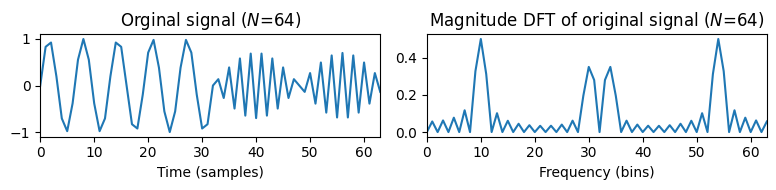

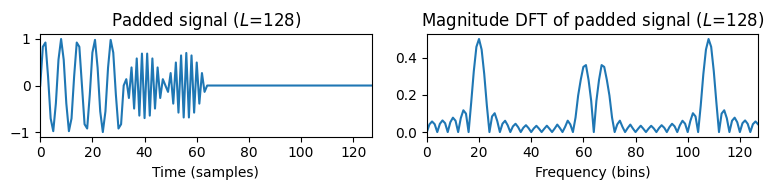

In [12]:
Fs = 32
duration = 2
freq1 = 5
freq2 = 15
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * freq1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * freq2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))

ax1 = plt.subplot(1, 2, 1)
plt.plot(x)
plt.title('Orginal signal ($N$=%d)' % N)
plt.xlabel('Time (samples)')
plt.xlim([0, N - 1])
plt.subplot(1, 2, 2)
Y = np.abs(np.fft.fft(x)) / Fs
plt.plot(Y)
plt.title('Magnitude DFT of original signal ($N$=%d)' % N)
plt.xlabel('Frequency (bins)')
plt.xlim([0, N - 1])
plt.tight_layout()

L = 2 * N
pad_len = L - N
t_tilde = np.concatenate((t, np.arange(len(x), len(x) + pad_len) / Fs))
x_tilde = np.concatenate((x, np.zeros(pad_len)))
                         
plt.figure(figsize=(8, 2))
ax1 = plt.subplot(1, 2, 1)
plt.plot(x_tilde)
plt.title('Padded signal ($L$=%d)' % L)
plt.xlabel('Time (samples)')
plt.xlim([0, L - 1])
plt.subplot(1, 2, 2)
Y_tilde = np.abs(np.fft.fft(x_tilde)) / Fs
plt.plot(Y_tilde)
plt.title('Magnitude DFT of padded signal ($L$=%d)' % L)
plt.xlabel('Frequency (bins)')
plt.xlim([0, L - 1])

plt.tight_layout()                       

- 다음 코드 예제는 증가된 주파수 그리드 해상도로 DFT를 계산하는 함수를 구현한다. 
- 여기에서 모든 파라미터는 물리적 방식으로 해석된다(초 및 헤르츠 기준).

In [13]:
def compute_plot_DFT_extended(t, x, Fs, L):
    N = len(x)
    pad_len = L - N
    t_tilde = np.concatenate((t, np.arange(len(x), len(x) + pad_len) / Fs))
    x_tilde = np.concatenate((x, np.zeros(pad_len)))
    Y = np.abs(np.fft.fft(x_tilde)) / Fs    
    Y = Y[:L//2]
    freq = np.arange(L//2)*Fs/L
    # freq = np.fft.fftfreq(L, d=1/Fs)
    # freq = freq[:L//2]
    plt.figure(figsize=(10, 2))
    
    ax1 = plt.subplot(1, 3, 1)
    plt.plot(t_tilde, x_tilde)
    plt.title('Signal ($N$=%d)' % N)
    plt.xlabel('Time (seconds)')
    plt.xlim([t[0], t[-1]])
    
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(t_tilde, x_tilde)
    plt.title('Padded signal (of size $L$=%d)' % L)
    plt.xlabel('Time (seconds)')
    plt.xlim([t_tilde[0], t_tilde[-1]])    
    
    ax3 = plt.subplot(1, 3, 3)
    plt.plot(freq, Y)
    plt.title('Magnitude DFT of padded signal ($L$=%d)' % L)
    plt.xlabel('Frequency (Hz)')
    plt.xlim([freq[0], freq[-1]])
    plt.tight_layout()           

    return ax1, ax2, ax3

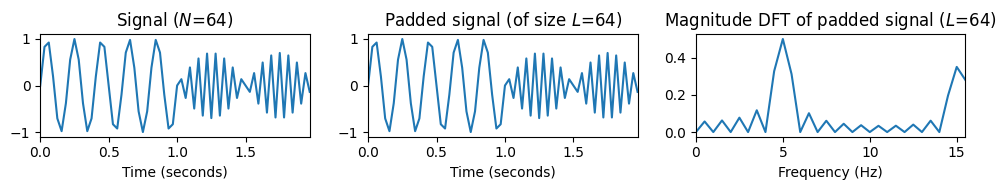

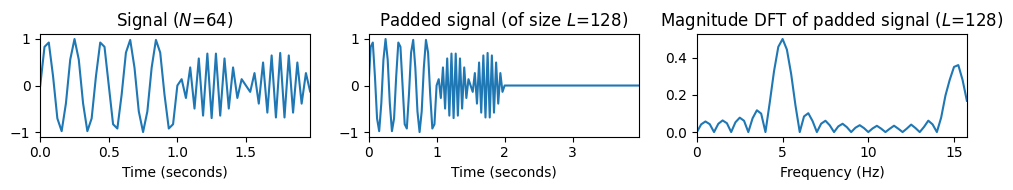

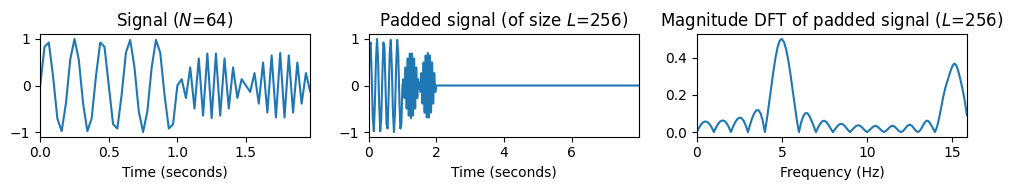

In [14]:
N = len(x)

L = N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

L = 2 * N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

L = 4 * N
ax1, ax2, ax3 = compute_plot_DFT_extended(t, x, Fs, L)

## 주파수 그리드 해상도가 증가된 STFT

- 이제 동일한 제로-패딩 전략을 사용하여 STFT의 주파수 그리드 해상도를 높이는 방법을 보자. `librosa` 함수 `librosa.stft`는 두 개의 파라미터 `n_fft`($L$에 해당) 및 `win_length`($N$에 해당)를 통해 이 아이디어를 구현한다. 파라미터를 물리적 도메인으로 변환할 때 주의해야 한다. 

- 바이올린이 연주하는 음표 C4의 예를 보자

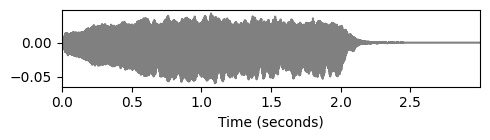

In [15]:
x, Fs = librosa.load("../audio/violin_c4_legato.wav")
ipd.display(ipd.Audio(x, rate=Fs))

t_wav = np.arange(0, x.shape[0]) * 1 / Fs
plt.figure(figsize=(5, 1.5))
plt.plot(t_wav, x, c='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)')
plt.tight_layout()

- 이제 제로 패딩으로 STFT를 계산한다. 그림에서 축은 시간 프레임 및 주파수 빈으로 표시된다.

In [16]:
def compute_stft(x, Fs, N, H, L=N, pad_mode='constant', center=True):    
    X = librosa.stft(x, n_fft=L, hop_length=H, win_length=N, 
                     window='hann', pad_mode=pad_mode, center=center)
    Y = np.log(1 + 100 * np.abs(X) ** 2)
    F_coef = librosa.fft_frequencies(sr=Fs, n_fft=L)
    T_coef = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H) 
    return Y, F_coef, T_coef

def plot_compute_spectrogram(x, Fs, N, H, L, color='gray_r'):
    Y, F_coef, T_coef = compute_stft(x, Fs, N, H, L)
    plt.imshow(Y, cmap=color, aspect='auto', origin='lower')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (bins)')
    plt.title('L=%d' % L)
    plt.colorbar()

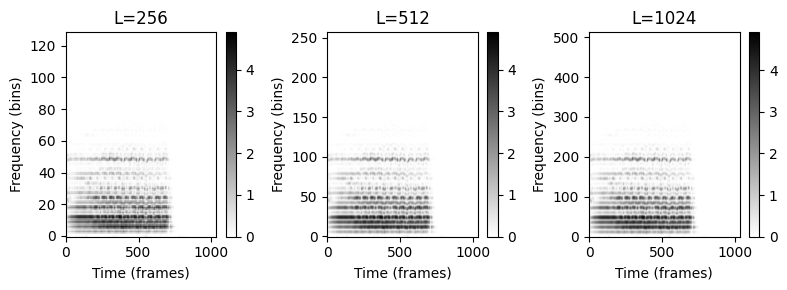

In [17]:
N = 256
H = 64
color = 'gray_r' 
plt.figure(figsize=(8, 3))

L = N
plt.subplot(1,3,1)
plot_compute_spectrogram(x, Fs, N, H, L)

L = 2 * N
plt.subplot(1,3,2)
plot_compute_spectrogram(x, Fs, N, H, L)

L = 4 * N
plt.subplot(1,3,3)
plot_compute_spectrogram(x, Fs, N, H, L)

plt.tight_layout()

- 다음으로 동일한 계산을 반복한다. 여기서 축은 이제 초와 헤르츠로 지정된 물리적 단위를 표시하도록 변환된다. 또한 시간-주파수 평면을 확대하여 밀도가 높은 주파수 그리드 밀도의 효과를 강조한다.

In [18]:
def plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim, ylim, color='gray_r'):
    Y, F_coef, T_coef = compute_stft(x, Fs, N, H, L)
    extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
    plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title('L=%d' % L)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.colorbar()

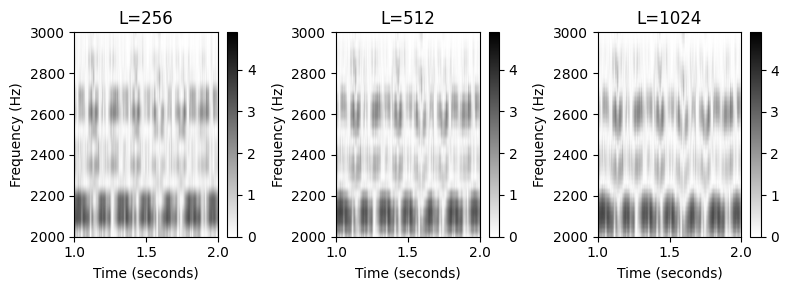

In [19]:
xlim_sec = [1, 2]
ylim_hz = [2000, 3000]

plt.figure(figsize=(8, 3))

L = N
plt.subplot(1,3,1)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

L = 2 * N
plt.subplot(1,3,2)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

L = 4 * N
plt.subplot(1,3,3)
plot_compute_spectrogram_physical(x, Fs, N, H, L, xlim=xlim_sec, ylim=ylim_hz)

plt.tight_layout()

- `librosa` 함수 `librosa.stft`는 두 개의 파라미터 `n_fft`(패딩된 섹션의 크기 $L$에 해당) 및 `win_length`($N$에 해당, 윈도우 부분)가 있다. 이 패딩 변형을 $L$($N$ 대신)와 함께 사용하면, 함수 $F_\mathrm{coef}$의 계산을 다음과 같이 조정해야 한다.
\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{L} 
\end{equation}
for $k\in [0:K]$ 
with $K=L/2$. 

- 반올림 문제를 방지하려면 짝수 $L$(아마도 2의 거듭제곱)를 선택하는 것이 좋다.

F_coef 결과가 같은가: True
Y.shape = (257,1034)


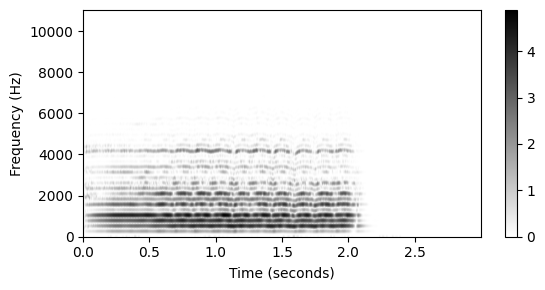

In [20]:
N = 256
L = 512
H = 64
color = 'gray_r' 

X = librosa.stft(x, n_fft=L, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True) # center에 대해서는 밑에서 다루기로 한다
Y = np.log(1 + 100 * np.abs(X) ** 2)

T_coef = np.arange(0, X.shape[1]) * H / Fs

K = L // 2
F_coef = np.arange(K + 1) * Fs / L # 공식에 따라
F_coef_librosa = librosa.fft_frequencies(sr=Fs, n_fft=L) # librosa 내장
print('F_coef 결과가 같은가:', np.allclose(F_coef, F_coef_librosa))
print('Y.shape = (%d,%d)'%(Y.shape[0],Y.shape[1]))

plt.figure(figsize=(6, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()

# 주파수 그리드 보간법 (Frequency Grid Interpolation)

- 위에서는 STFT 계산에서 윈도우 섹션을 적절하게 패딩하여 밀도를 높이는 방법을 보았다. 
- 대안으로 주파수 해상도를 조정하기 위해 주파수 방향을 따른 보간법(interpolation) 기술에 대해 논의한다.

## 보간법 Interpolation

- 데이터 포인트 시퀀스가 주어지면 **보간법 interpolation**의 목표는 의미 있는 방식으로 시퀀스를 정제(refine)하는 중간(intermediate) 데이터 포인트를 계산하는 것이다.

- 보다 구체적으로, 파라미터 $t\in\mathbb{R}$를 $f(t)\in\mathbb{R}$로 매핑하는 $f\colon\mathbb{R}\to\mathbb{R}$ 함수를 고려해보자.

- $n\in\mathbb{Z}$에 대한 파라미터 $t_n\in\mathbb{R}$의 이산 집합에 대해서만 $f(t_n)$ 값이 있다고 가정하자. $t_{n} > t_ {n-1}$.
- 그런 다음 interpolation의 목표는 $f^\ast(t)$ 값을 추정하는 것이다. $f(t_n)$는 다음과 같이 주어진다.
$$
f^\ast(t) \approx f(t)
$$
for any $t\in\mathbb{R}$

- 실제로는 $f$ 함수는 알 수 없지만, 종종 $f$의 연속성, 평활성, 미분 가능성 등과 같은 특정 속성을 가정한다.

- 가장 간단한 보간법 방법은 **조각 상수 보간**(또는 **최근접 이웃 보간**)이다. 파라미터 $t\in\mathbb{R}$가 주어지면, 가장 가까운 파라미터 $t_n$을 취하여 다음을 정의한다.
    - $f^\ast(t)=f(t_n).$

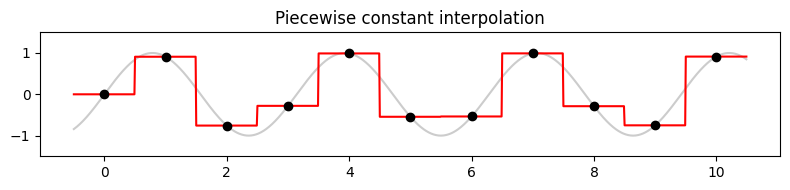

In [21]:
# Simulates the original function
t = np.arange(-0.5, 10.5, 0.01)
f = np.sin(2 * t)

# Known funcion values
t_n = np.arange(0, 11)
f_n = np.sin(2 * t_n)

# Interpolation
f_interpol_nearest = interp1d(t_n, f_n, kind='nearest', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_nearest, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Piecewise constant interpolation')
plt.tight_layout()

- Nearest-neighbor 보간법은 일반적으로 이산 함수를 생성한다. 연속적인 보간법 함수를 얻기 위한 간단한 대안으로는 선형 보간법(linear interpolation)이 있다.

- $t_{n-1}$와 $t_n$ 사이에 있는 파라미터 $t$가 주어지면, 다음과 같이 정의할 수 있다.
$$
f^\ast(t)=f(t_{n-1}) + (f(t_{n})-f(t_{n-1}))\cdot\frac{t-t_{n-1}}{t_{n} - t_{n-1}}. 
$$

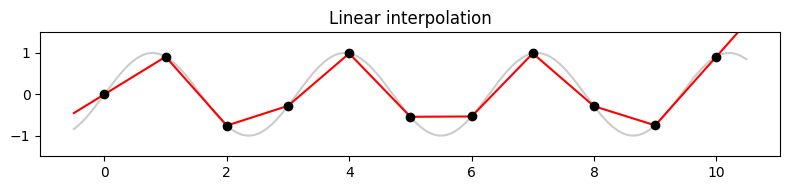

In [22]:
f_interpol_linear = interp1d(t_n, f_n, kind='linear', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_linear, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Linear interpolation')
plt.tight_layout()

- Python 클래스 scipy.inperploate.interp1d는 Nearest-neighbor, 선형 및 다양한 차수의 spline 보간을 포함하여 여러 종류의 보간 방법을 제공한다. 또 다른 예로, 3차 보간(3차 스플라인)에 대한 결과를 보자.

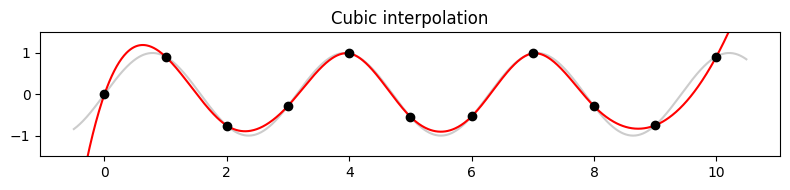

In [23]:
f_interpol_cubic = interp1d(t_n, f_n, kind='cubic', fill_value='extrapolate')(t)

plt.figure(figsize=(8, 2)) 
plt.plot(t, f, color=(0.8, 0.8, 0.8))
plt.plot(t, f_interpol_cubic, 'r-')
plt.plot(t_n, f_n, 'ko')
plt.ylim([-1.5,1.5])
plt.title('Cubic interpolation')
plt.tight_layout()

## 주파수 보간법 (Frequency Interpolation)

- 선형 주파수 그리드의 밀도를 증가시키기 위해 제로 패딩을 기반으로 더 큰 DFT를 사용할 수 있었다. 이제 주파수 영역에서 보간법을 적용하여 대안을 소개한다.

- $x\in \mathbb{R}^N$를 길이 $N\in\mathbb{N}$, 샘플링 레이트 $F_\mathrm{s}$, DFT $X = \mathrm{DFT} _N \cdot x$, 및 DFT 크기 $Y=|X|$의 이산 신호라고 하자. 그러면 $Y(k)$의 인덱스 $k$는 다음의 헤르츠로 주어진 물리적 주파수에 해당한다.

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N}
\end{equation}


- 즉, 주파수 그리드 결과의 해상도는 $F_\mathrm{s}/N$이다. 팩터 $\rho\in\mathbb{N}$를 도입하여, 해상도 $F_\mathrm{s}/(\rho\cdot N)$를 고려하여 주파수 그리드를 정제(refine)한다. 이 주파수 그리드를 기반으로 보간 기술을 사용하여 크기 주파수 계수(magnitude frequency coefficient)를 계산한다.

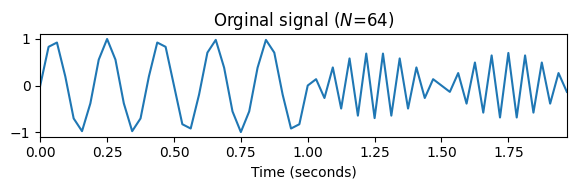

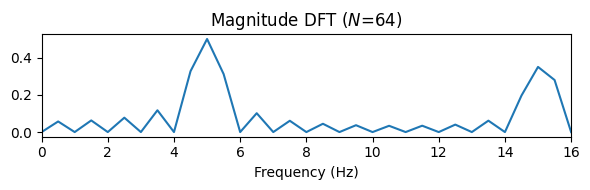

In [24]:
Fs = 32
duration = 2
omega1 = 5
omega2 = 15
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(6, 2))
plt.plot(t, x)
plt.title('Orginal signal ($N$=%d)' % N)
plt.xlabel('Time (seconds)')
plt.xlim([t[0], t[-1]])   
plt.tight_layout()

Y = np.abs(np.fft.fft(x)) / Fs
Y = Y[:N//2+1]
F_coef = np.arange(N//2+1)*Fs/N
plt.figure(figsize=(6, 2))
plt.plot(F_coef,Y)
plt.title('Magnitude DFT ($N$=%d)' % N)
plt.xlabel('Frequency (Hz)')
plt.xlim([F_coef[0], F_coef[-1]])     
plt.tight_layout()

In [25]:
def interpolate_plot_DFT(N, Fs, F_coef, rho, int_method):
    F_coef_interpol = np.arange(F_coef[0], F_coef[-1], Fs/(rho*N))
    Y_interpol = interp1d(F_coef, Y, kind=int_method)(F_coef_interpol)
    plt.figure(figsize=(6, 2))
    plt.plot(F_coef_interpol, Y_interpol)
    plt.title(r'Magnitude DFT (interpolation: %s, $\rho$=%d)'%(int_method,rho))
    plt.xlabel('Frequency (Hz)')
    plt.xlim([F_coef[0], F_coef[-1]])
    plt.tight_layout()

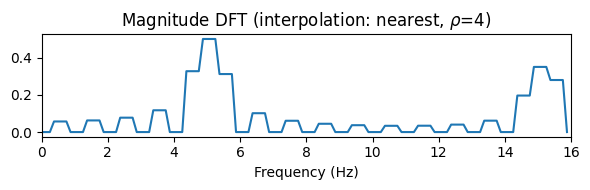

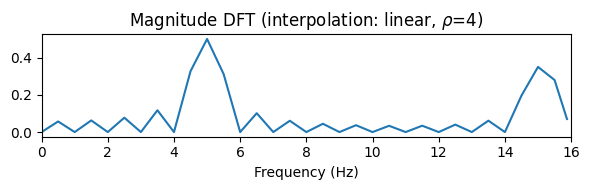

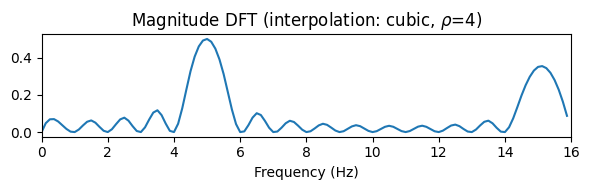

In [26]:
rho = 4
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='nearest')
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='linear')
interpolate_plot_DFT(N=N, Fs=Fs, F_coef=F_coef, rho=rho, int_method='cubic')

## STFT를 위한 보간법

- STFT의 주파수 그리드를 정제하기 위해서 주파수 방향을 따라 보간법을 적용할 수 있다.

- 이전과 같은 바이올린(C4)의 예로 보자.

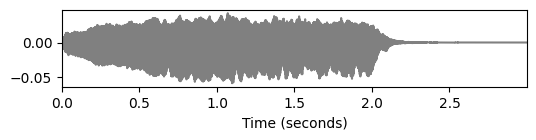

In [27]:
x, Fs = librosa.load("../audio/violin_c4_legato.wav")
ipd.display(ipd.Audio(x, rate=Fs))

t_wav = np.arange(0, x.shape[0]) * 1 / Fs
plt.figure(figsize=(6, 1))
plt.plot(t_wav, x, c='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)');

In [28]:
def stft_convention_fmp(x, Fs, N, H, pad_mode='constant', center=True, mag=False, gamma=0):
    """Compute the discrete short-time Fourier transform (STFT)

    Args:
        x (np.ndarray): Signal to be transformed
        Fs (scalar): Sampling rate
        N (int): Window size
        H (int): Hopsize
        pad_mode (str): Padding strategy is used in librosa (Default value = 'constant')
        center (bool): Centric view as used in librosa (Default value = True)
        mag (bool): Computes magnitude STFT if mag==True (Default value = False)
        gamma (float): Constant for logarithmic compression (only applied when mag==True) (Default value = 0)

    Returns:
        X (np.ndarray): Discrete (magnitude) short-time Fourier transform
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N,
                     window='hann', pad_mode=pad_mode, center=center)
    if mag:
        X = np.abs(X)**2
        if gamma > 0:
            X = np.log(1 + gamma * X)
    F_coef = librosa.fft_frequencies(sr=Fs, n_fft=N)
    T_coef = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H)
    # T_coef = np.arange(X.shape[1]) * H/Fs
    # F_coef = np.arange(N//2+1) * Fs/N
    return X, T_coef, F_coef


def compute_f_coef_linear(N, Fs, rho=1):
    """Refines the frequency vector by factor of rho

    Args:
        N (int): Window size
        Fs (scalar): Sampling rate
        rho (int): Factor for refinement (Default value = 1)

    Returns:
        F_coef_new (np.ndarray): Refined frequency vector
    """
    L = rho * N
    F_coef_new = np.arange(0, L//2+1) * Fs / L
    return F_coef_new


def interpolate_freq_stft(Y, F_coef, F_coef_new):
    """Interpolation of STFT along frequency axis

    Args:
        Y (np.ndarray): Magnitude STFT
        F_coef (np.ndarray): Vector of frequency values
        F_coef_new (np.ndarray): Vector of new frequency values

    Returns:
        Y_interpol (np.ndarray): Interploated magnitude STFT
    """
    compute_Y_interpol = interp1d(F_coef, Y, kind='cubic', axis=0)
    Y_interpol = compute_Y_interpol(F_coef_new)
    return Y_interpol


def plot_compute_spectrogram_physical(x, Fs, N, H, xlim, ylim, rho=1, color='gray_r'):
    Y, T_coef, F_coef = stft_convention_fmp(x, Fs, N, H, mag=True, gamma=100)
    F_coef_new = compute_f_coef_linear(N, Fs, rho=rho)
    Y_interpol = interpolate_freq_stft(Y, F_coef, F_coef_new)    
    extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
    plt.imshow(Y_interpol, cmap=color, aspect='auto', origin='lower', extent=extent)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.title(r'$\rho$=%d' % rho)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.colorbar()

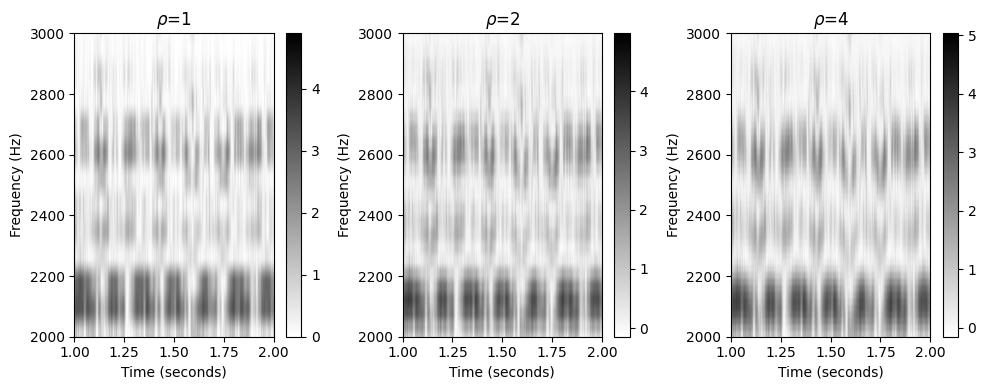

In [29]:
xlim_sec = [1, 2]
ylim_hz = [2000, 3000]

N = 256
H = 64
plt.figure(figsize=(10, 4))
 
plt.subplot(1, 3, 1)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=1)

plt.subplot(1, 3, 2)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=2)

plt.subplot(1, 3, 3)
plot_compute_spectrogram_physical(x, Fs, N, H, xlim=xlim_sec, ylim=ylim_hz, rho=4)

plt.tight_layout()

## 로그-주파수 STFT

- 이 보간법은 주파수 그리드의 비선형 변형에 사용될 수 있다. 예를 들어 선형 간격의 주파수 축(헤르츠로 측정)을 로그 간격의 주파수 축(피치 또는 센트로 측정)으로 변환할 수 있다. 

- 로그 간격의 주파수 그리드를 정의하는 것이 주요 단계이다. 이때 음정에 사용되는 대수 측정 단위인 **센트**라는 개념을 사용한다. 참조 주파수 $\omega_0$가 주어지면 임의의 주파수 $\omega$와 $\omega_0$ 사이의 거리는 다음과 같이 지정된다.
$$
      \log_2\left(\frac{\omega}{\omega_0}\right)\cdot 1200
$$
given in cents.

- 다음 함수에서는 최소 주파수 값(매개변수 `F_min`이 기준 주파수 $\omega_0$로 사용되므로 $0$ cents에 해당함)에서 시작하여 로그 간격의 주파수 축을 계산한다. 
- 또한 이 함수에는 로그 해상도를 센트 단위로 지정하는 파라미터 `R`이 있다. 즉, 로그 주파수 축에서 두 개의 연속된 주파수 빈은 `R` 센트 떨어져 있다. 
- 최대 주파수는 다른 매개변수 `F_max`에 의해 지정된다.

- 다음 예에서 주파수 `F_min = 100`($0$ 센트에 해당) 및 `F_max = 3200`($6000$ 센트에 해당)을 사용한다. 또한 해상도는 `R=20`(옥타브당 $60$ 주파수 빈에 해당)으로 설정한다.

In [30]:
def compute_f_coef_log(R, F_min, F_max):
    """Adapts the frequency vector in a logarithmic fashion

    Args:
        R (scalar): Resolution (cents)
        F_min (float): Minimum frequency
        F_max (float): Maximum frequency (not included)

    Returns:
        F_coef_log (np.ndarray): Refined frequency vector with values given in Hz)
        F_coef_cents (np.ndarray): Refined frequency vector with values given in cents.
            Note: F_min serves as reference (0 cents)
    """
    n_bins = np.ceil(1200 * np.log2(F_max / F_min) / R).astype(int)
    F_coef_log = 2 ** (np.arange(0, n_bins) * R / 1200) * F_min
    F_coef_cents = 1200 * np.log2(F_coef_log / F_min)
    return F_coef_log, F_coef_cents

In [31]:
N = 1024
H = 256
Y, T_coef, F_coef = stft_convention_fmp(x, Fs, N, H, mag=True, gamma=100)

F_min = 100
F_max = 3200
R = 20
F_coef_log, F_coef_cents = compute_f_coef_log(R, F_min, F_max)

print('#bins=%3d, F_coef[0]      =%6.2f, F_coef[1]      =%6.2f, F_coef[-1]      =%6.2f'%(len(F_coef),F_coef[0], F_coef[1], F_coef[-1]))
print('#bins=%3d, F_coef_log[0]  =%6.2f, F_coef_log[1]  =%6.2f, F_coef_log[-1]  =%6.2f'%(len(F_coef_log),F_coef_log[0], F_coef_log[1], F_coef_log[-1]))
print('#bins=%3d, F_coef_cents[0]=%6.2f, F_coef_cents[1]=%6.2f, F_coef_cents[-1]=%6.2f'%(len(F_coef_cents),F_coef_cents[0], F_coef_cents[1], F_coef_cents[-1]))

#bins=513, F_coef[0]      =  0.00, F_coef[1]      = 21.53, F_coef[-1]      =11025.00
#bins=300, F_coef_log[0]  =100.00, F_coef_log[1]  =101.16, F_coef_log[-1]  =3163.24
#bins=300, F_coef_cents[0]=  0.00, F_coef_cents[1]= 20.00, F_coef_cents[-1]=5980.00


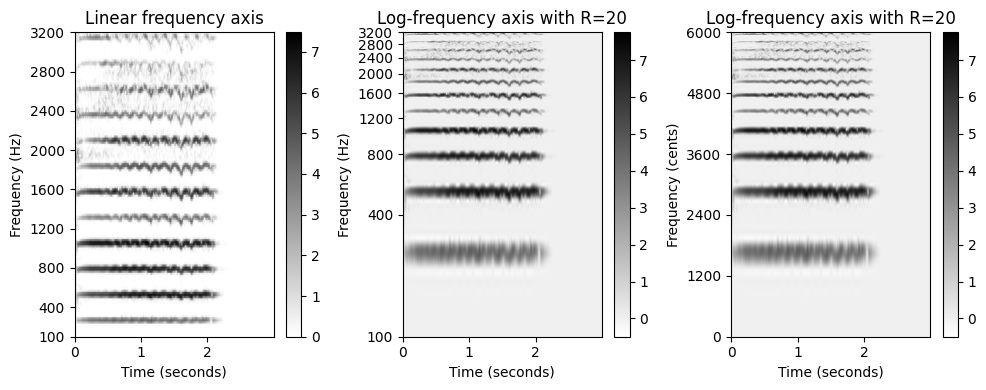

In [32]:
Y_interpol = interpolate_freq_stft(Y, F_coef, F_coef_log)
color = 'gray_r' 

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
extent=[T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
y_ticks_freq = np.array([100, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200])
plt.yticks(y_ticks_freq)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Linear frequency axis')
plt.ylim([F_min, F_max])
plt.colorbar()

plt.subplot(1, 3, 2)
extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]]
plt.imshow(Y_interpol, cmap=color, aspect='auto', origin='lower', extent=extent)
y_tick_freq_cents = 1200 * np.log2(y_ticks_freq / F_min)
plt.yticks(y_tick_freq_cents, y_ticks_freq)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Log-frequency axis')
plt.title('Log-frequency axis with R=%d' % R)
plt.colorbar()

plt.subplot(1, 3, 3)
extent=[T_coef[0], T_coef[-1], F_coef_cents[0], F_coef_cents[-1]]
plt.imshow(Y_interpol, cmap=color, aspect='auto', origin='lower', extent=extent)
y_ticks_cents = np.array([0, 1200, 2400, 3600, 4800, 6000])
plt.yticks(y_ticks_cents)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (cents)')
plt.title('Log-frequency axis')
plt.title('Log-frequency axis with R=%d' % R)
plt.colorbar()
plt.tight_layout()

# STFT: Conventions and Implementations

## 샘플 신호에 대한 시간 축 컨벤션
- $x=(x(0),x(1), \ldots x(L-1))^\top \in \mathbb{R}^L$을 길이가 $L\in\mathbb{N}$인 이산-시간 신호라고 가정하자. 또한 $F_\mathrm{s}$를 샘플 레이트라고 하자.

- 그런 다음 물리적 시간 위치(초 단위로 표시)의 벡터 $t=(t(0),t(1), \ldots t(L-1))^\top \in \mathbb{R}^L$을 $x$에 대입하면 다음과 같이 정의된다.
$$
     t(n) = \frac{n}{F_\mathrm{s}}
$$
for $n\in[0:L-1]$

- 다시 말해,
    * 샘플 $x(0)$는 물리적 시간 $t(0)=0$(초 단위로 표시됨)와 연관된다.
    * 신호 $x$의 기간(duration)(초 단위)은 샘플 수를 샘플링 속도로 나눈 것이다: $L/F_\mathrm{s}$. 단, 이것은 $t(L-1)=(L-1)/F_\mathrm{s}$와 **동일하지 않다**.
    * 두 샘플 $x(n-1)$ 및 $x(n)$ 사이의 거리(**샘플링 기간 sampling period**이라고 함)는 $1/F_\mathrm{s}$이다.

t[0] = 0.0000, t[-1] = (L-1)/Fs = 3.0000, Fs = 22050, L = 66150, dur_x=3.0000


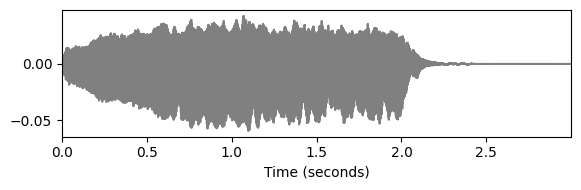

In [33]:
x, Fs = librosa.load("../audio/violin_c4_legato.wav")
ipd.Audio(x, rate=Fs)
L = x.shape[0] #샘플 수
t_wav = np.arange(L) / Fs
x_duration = L / Fs #듀레이션

print('t[0] = %0.4f, t[-1] = (L-1)/Fs = %0.4f, Fs = %0.0f, L = %0.0f, dur_x=%0.4f'
      % (t_wav[0], t_wav[-1], Fs, L, x_duration))
ipd.display(ipd.Audio(x, rate=Fs))

plt.figure(figsize=(6, 2))
plt.plot(t_wav, x, color='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)')
plt.tight_layout()

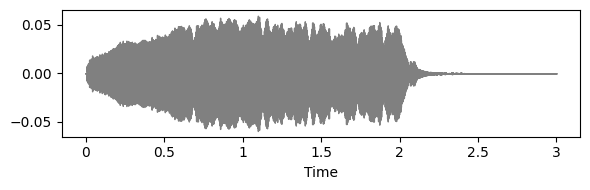

In [34]:
# librosa를 이용한 plot
# 단 librosa는 파형의 샘플이 아닌 symmetric amplitude envelope를 그림

plt.figure(figsize=(6, 2))
librosa.display.waveshow(x, color='gray')
plt.tight_layout()

## 중심 윈도우와 시간 변환 (Centered Windowing and Time Conversion)

- 신호의 윈도우 부분을 고려할 때 **중앙 centered** 시점을 채택한다. 여기서 윈도우의 중심이란 물리적 도메인과 관련된 참조로 사용된다. 
- 특히 STFT를 계산할 때, 윈도우 길이의 절반의 제로-패딩을 적용하여 신호를 왼쪽으로 확장한다. 
- 보다 정확히 말하면, $w:[0:N-1]\to\mathbb{R}$를 짝수 윈도우 길이 $N\in\mathbb{N}$의 윈도우 함수라고 하고 $H\in\mathbb{ N}$를 홉(hop) 크기라고 하자. 그리고 $N/2$개 0값을 앞에 넣는다.

$$
\tilde{x}=(0,\ldots,0,x(0),x(1), \ldots x(L-1))^\top \in \mathbb{R}^{L+N/2}
$$

\begin{eqnarray}
   \mathcal{X}(m,k):= \sum_{n=0}^{N-1} \tilde{x}(n+mH)w(n)\mathrm{exp}(-2\pi ikn/N).
\end{eqnarray} 

- 또한 프레임 인덱스 $m$이 물리적 시간 위치와 연관되어 있는 규칙을 사용한다.
    - $T_\mathrm{coef}(m) := \frac{m\cdot H}{F_\mathrm{s}}$
    - given in seconds. 

- 특히 다음이 성립한다.
    * 프레임 인덱스 $m=0$는 물리적 시간 $T_\mathrm{coef}(0)=0$(초 단위)에 해당한다.
    * 시간 해상도(즉, 연속되는 두 프레임 사이의 거리)은 $\Delta t = H/F_\mathrm{s}$(초 단위)이다.

## 주파수 변환 (Frequency Conversion)

- $x$ 및 $w$가 실수이면 주파수 계수의 상위 절반이 중복된다. 따라서 계수 $k\in[0:K]$ ($K=N/2$)만 사용된다. 

- 특히 인덱스 $k=N/2$는 나이퀴스트(Nyquist) 주파수 $\omega=F_\mathrm{s}/2$에 해당한다. 

- 또한 인덱스 $k$는 다음의 주파수에 해당한다.
    - $F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N}$
    - given in Hertz. 


## 스펙트로그램 시각화

- 다음 코드는 이러한 규칙을 구현하기 위해 `librosa` 함수 `librosa.stft`를 사용하는 방법을 보여준다. 파라미터 설정 `center=True`는 centered view를 활성화하고 `pad_mode='constant'`는 제로-패딩 모드로 전환한다. 
- 또한 이 코드는 변환 함수 $T_\mathrm{coef}$ 및 $F_\mathrm{coef}$를 한 번은 위의 공식을 사용하고 한 번은 `librosa` 내장 함수를 사용하여 구현하는 방법을 보여준다. 홀수 윈도우 크기 $N$의 경우 반올림에 대한 다른 규칙이 있을 수 있다. 실제로는 일반적으로 **짝수** 윈도우 크기를 사용한다(특히 FFT algorithm 관점에서 2의 거듭제곱임).

T_coef 계산 결과가 같은가: True
F_coef 계산 결과가 같은가: True


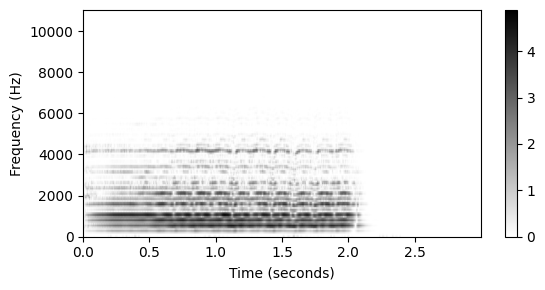

In [35]:
N = 256
H = 64
color = 'gray_r' 

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
Y = np.log(1 + 100 * np.abs(X) ** 2)

T_coef = np.arange(X.shape[1]) * H / Fs #위의 공식
T_coef_librosa = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H) #librosa 내장
print('T_coef 계산 결과가 같은가:', np.allclose(T_coef, T_coef_librosa))

K = N // 2
F_coef = np.arange(K+1) * Fs / N #위의 공식
F_coef_librosa = librosa.fft_frequencies(sr=Fs, n_fft=N) #librosa 내장
print('F_coef 계산 결과가 같은가:', np.allclose(F_coef, F_coef_librosa))

plt.figure(figsize=(6, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()
plt.show()

- 시각화에서 centered view를 채택하려면 프레임 길이의 절반만큼 왼쪽 및 오른쪽 여백을 조정하고, 빈(bin) 너비의 절반만큼 아래쪽 및 위쪽 여백을 조정해야 한다. 
- 그러나 큰 스펙트로그램의 경우 시각화의 이러한 작은 조정은 상관 없다.

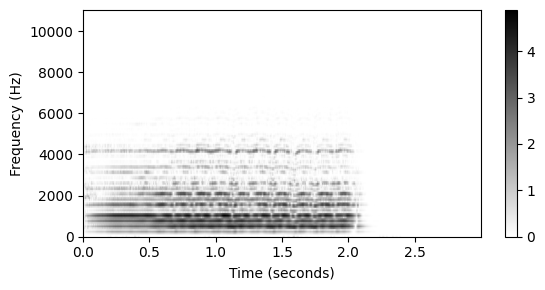

In [36]:
plt.figure(figsize=(6, 3))
extent = [T_coef[0] - (H / 2) / Fs, T_coef[-1] + (H / 2) / Fs,
          F_coef[0] - (Fs / N) / 2, F_coef[-1] + (Fs / N) / 2]
plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
plt.xlim([T_coef[0], T_coef[-1]])
plt.ylim([F_coef[0], F_coef[-1]])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()

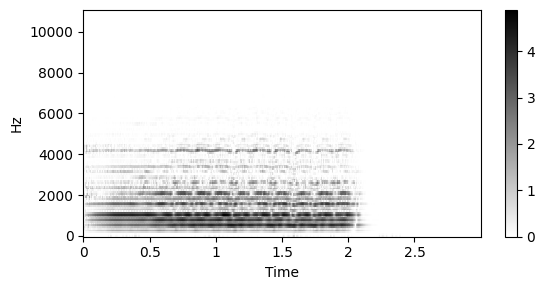

In [37]:
# librosa의 내장 함수로 결과를 비교하자

plt.figure(figsize=(6, 3))
librosa.display.specshow(Y, y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap=color)
plt.colorbar()
plt.tight_layout()

# 역 푸리에 변형 (Inverse Fourier Transform)

## Inverse DFT

- $N\in\mathbb{N}$ 길이의 벡터 $x\in \mathbb{C}^N$가 주어지면 DFT은 행렬-벡터 곱으로 정의된다.
    - $X = \mathrm{DFT}_N \cdot x$
    - with DFT 행렬 $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ given by
    - $ \mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N) $
    - for $n\in[0:N-1]$ and $k\in[0:N-1]$. 

- DFT는 벡터 $x$를 스펙트럼 벡터 $X$에서 복구할 수 있다는 점에서 **invertible**하다. 역 DFT는 행렬-벡터 곱으로 다시 지정된다.
    - $ x = \mathrm{DFT}_N^{-1} \cdot X, $

- 여기서 $\mathrm{DFT}_N^{-1}$는 DFT 행렬 $\mathrm{DFT}_N$의 **역**을 나타낸다.
    - $ \mathrm{DFT}_N^{-1}(n, k) = \frac{1}{N}\mathrm{exp}(2 \pi i k n / N) $
    - for $n\in[0:N-1]$ and $k\in[0:N-1]$. 

- 즉, 역함수는 본질적으로 일부 정규화 인자(normalizing factor) 및 켤레 복소수(complex conjugation)까지 DFT 행렬과 일치한다. 

- 다음 코드 셀에서 DFT 행렬과 그 역행렬을 생성한다. 또한 두 행렬이 실제로 서로 역임을 보여준다. 
    - 이를 위해 $\mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}$와 항등 행렬 $I_N\in \mathbb{R}^{N\times N}$의 차이, 그리고 $\mathrm{DFT}_N^{-1} \cdot\mathrm{DFT}_N$와 $I_N$의 차이를 측정한다.

In [38]:
def generate_matrix_dft(N, K):
    """Generates a DFT (discrete Fourier transfrom) matrix
    Args:
        N (int): Number of samples
        K (int): Number of frequency bins
    Returns:
        dft (np.ndarray): The DFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k, n] = np.exp(-2j * np.pi * k * n / N)
    return dft

def generate_matrix_dft_inv(N, K):
    """Generates an IDFT (inverse discrete Fourier transfrom) matrix
    Args:
        N (int): Number of samples
        K (int): Number of frequency bins
    Returns:
        dft (np.ndarray): The IDFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k, n] = np.exp(2j * np.pi * k * n / N) / N
    return dft

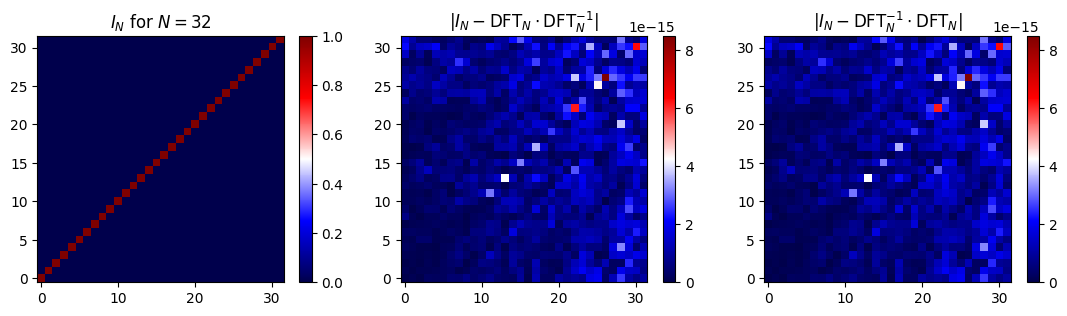

In [39]:
N = 32
dft_mat = generate_matrix_dft(N, N)
dft_mat_inv = generate_matrix_dft_inv(N, N)

I = np.eye(N)
A =  np.dot(dft_mat, dft_mat_inv)
B =  np.dot(dft_mat_inv, dft_mat)

plt.figure(figsize=(11, 3))

plt.subplot(1, 3, 1)
plt.title(r'$I_N$ for $N = %d$'%N)
plt.imshow(I, origin='lower', cmap='seismic', aspect='equal')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title(r'$|I_N - \mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}|$')
plt.imshow(np.abs(I-A), origin='lower', cmap='seismic', aspect='equal')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title(r'$|I_N - \mathrm{DFT}_N^{-1} \cdot \mathrm{DFT}_N|$')
plt.imshow(np.abs(I-B), origin='lower', cmap='seismic', aspect='equal')
plt.colorbar();

plt.tight_layout()

- DFT는 FFT 알고리즘을 사용하여 효율적으로 계산할 수 있다. 역 DFT 계산에도 적용할 수 있다. 다음에서는 구현 numpy.fft.fft 및 numpy.fft.ifft를 사용한다.

## Inverse STFT

- 다음으로 이산 short-term Fourier transform을 inverting하는 법을 보자.


- $x:\mathbb{Z}\to\mathbb{R}$를 이산-시간 신호라고 하고, $\mathcal{X}$를 그것의 STFT라고 하자.


- 또한 $w:[0:N-1]\to\mathbb{R}$를 길이 $N\in\mathbb{N}$ 및 홉 크기 파라미터 $H\in\mathbb{N}$의 실수 값 이산 윈도우 함수를 나타낸다고 하자. 


- 표기상 편의를 위해 제로-패딩을 사용하여 윈도우 함수를 $w:\mathbb{Z}\to\mathbb{R}$로 확장한다.


- $x_n:\mathbb{Z}\to\mathbb{R}$를 다음에 의해 정의된 윈도우 신호라고 하자.
    - $x_n(r):=x(r+nH)w(r) $ for $r\in\mathbb{Z}$. 
    
    
- 그러면 STFT 계수 $\mathcal{X}(n,k)$ for $k\in[0:N-1]$가 다음에 의해 얻어진다.
    - $  (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top = 
  \mathrm{DFT}_N \cdot (x_n(0),\ldots, x_n(N-1))^\top.$
  
- $\mathrm{DFT}_N$가 invertible 행렬이기 때문에 STFT에서의 윈도우 신호 $x_n$를 다음과 같이 재구성할 수 있다.
   - $ (x_n(0),\ldots x_n(N-1))^\top = \mathrm{DFT}_N^{-1} \cdot (\mathcal{X}(n,0),\ldots, \mathcal{X}(n,N-1))^\top$ 
   - and $x_n(r)=0$ for $r\in\mathbb{Z}\setminus[0,N-1]$. 
   
   
- 원래 신호의 샘플 $x(r)$을 얻으려면 윈도우 프로세스를 반대로 해야 한다. 이것은 윈도우 프로세스에서 상대적으로 mild한 조건에서 가능하다는 것을 볼 수 있다. 신호의 윈도우 섹션의 적절하게 이동된 모든 버전에 대한 중첩(superposition)을 고려해 보자.
    - $
    \sum_{n\in\mathbb{Z}} x_n(r-nH)
    = \sum_{n\in\mathbb{Z}} x(r-nH+nH)w(r-nH)
    = x(r)\sum_{n\in\mathbb{Z}} w(r-nH).$
    
    
- 따라서 샘플 $x(r)$를 다음을 통해 복구할 수 있다.
    - **$$ x(r) = \frac{\sum_{n\in\mathbb{Z}} x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)}$$**
    - 단, 조건 $ \sum_{n\in\mathbb{Z}} w(r-nH)\not= 0$이 $r\in\mathbb{Z}$를 만족할 때. 
   
   
- 이 전반적인 접근 방식은 소위 **overlap&ndash;add technique**을 기반으로 한다. 이 기술에서는 겹치는 재구성된 윈도우 섹션이 단순히 오버레이되고 합산된다(그런 다음 windowing을 보상하기 위해 정규화됨).

## 단위 분할 (Partition of Unity)

- 위의 조건을 만족하는 홉 크기와 함께 윈도우 함수를 찾는 것은 어렵지 않다. 예를 들어 윈도우 함수 $w:[0:N-1]\to\mathbb{R}$가 양수이고 홉 크기가 윈도우 길이보다 작거나 같을 때 time-shifted 윈도우에 대한 합계는 항상 양수이다. 

- 종종 윈도우 함수와 홉 크기를 다음의 더 강한 조건으로 선택할 수도 있다.
    - $\sum_{n\in\mathbb{Z}} w(r-nH) = 1$ for all $r\in\mathbb{Z}$ is fulfilled. 
    
- 이 경우, time-shifted 윈도우 함수는 이산 시간 축 $\mathbb{Z}$의 **단위 분할 partition of unity**을 정의한다고 한다. 

- 예를 들어, 다음과 같이 정의된 윈도우 $w:\mathbb{Z}\to\mathbb{R}$로 **squared sinusoidal**을 사용할 때 단위 분할을 얻는다.
    - $w(r):= \left\{ \begin{array}{cl}
                 \sin(\pi r/N)^2 &  \,\mbox{if}\,\,\, r\in[0:N-1],\\
                 0 & \,\mbox{otherwise} ,
                 \end{array} \right. $
    - hop size of $H=N/2$

- 단위 분할이 되는 속성은 윈도우 함수 자체뿐만 아니라 홉 크기 파라미터에도 의존한다는 점에 유의해야 한다. 

- 다음 그림은 $N$ 길이의 다양한 윈도우 함수와 홉 크기 $H$를 사용하는 time-shifted 버전을 보여준다. time-shifted 버전의 합은 두꺼운 빨간색 곡선으로 표시된다.



In [40]:
def plot_sum_window(w, H, L, title='', figsize=(6, 2)):
    N = len(w)
    M = np.floor((L - N) / H).astype(int) + 1
    w_sum = np.zeros(L)
    plt.figure(figsize=figsize)
    for m in range(M):
        w_shifted = np.zeros(L)
        w_shifted[m * H:m * H + N] = w
        plt.plot(w_shifted, 'k')
        w_sum = w_sum + w_shifted
    plt.plot(w_sum, 'r', linewidth=3)
    plt.xlim([0, L-1])
    plt.ylim([0, 1.1*np.max(w_sum)])
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return w_sum

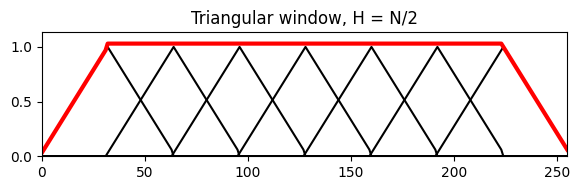

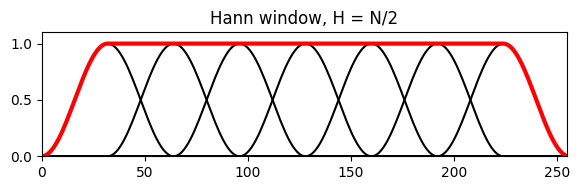

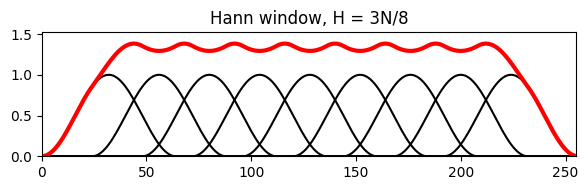

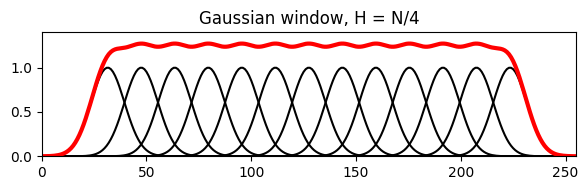

In [41]:
L = 256
N = 64

H = N//2
w_type = 'triang'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Triangular window, H = N/2');

H = N//2
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = N/2');

H = 3*N//8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
plot_sum_window(w, H, L, title='Hann window, H = 3N/8');

H = N//4
w = scipy.signal.gaussian(N, std=8)
plot_sum_window(w, H, L, title='Gaussian window, H = N/4');

## 구현

* 역 DFT에서 작은 허수값을 피하기 위해 재구성된 윈도우 신호의 실수 부분만 유지하는게 이득일 수 있다.

* 역 DFT를 적용한 후에는 윈도잉을 보상해야 한다. 프레임 기반 레벨에서(즉, 각 윈도우 섹션에 대해 개별적으로) 이 작업을 수행하는 것 보다는 모든 윈도우 신호와 이동된 모든 윈도우를 개별적으로 누적하여 **전역적으로(globally)** 보상을 수행해야 한다. 전역 보상이 가능한 이유는 DFT의 **선형성**에 있다. 또한 보상에서 0으로 나누기를 피해야 한다.

* 주어진 홉 크기에 대해 이동된 윈도우가 단위 분할(a partition of unity)을 형성하는 경우, 보상을 수행할 필요가 없다.

* STFT 계산에서 패딩이 적용된 경우 역 STFT 계산 시 이를 고려해야 한다.

In [51]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)
    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)
    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

def istft_basic(X, w, H, L):
    """Compute the inverse of the basic discrete short-time Fourier transform (ISTFT)
    Args:
        X (np.ndarray): The discrete short-time Fourier transform
        w (np.ndarray): Window function
        H (int): Hopsize
        L (int): Length of time signal
    Returns:
        x (np.ndarray): Time signal
    """
    N = len(w)
    M = X.shape[1]
    x_win_sum = np.zeros(L)
    w_sum = np.zeros(L)
    for m in range(M):
        x_win = np.fft.ifft(X[:, m])
        # Avoid imaginary values (due to floating point arithmetic)
        x_win = np.real(x_win)
        x_win_sum[m * H:m * H + N] = x_win_sum[m * H:m * H + N] + x_win
        w_shifted = np.zeros(L)
        w_shifted[m * H:m * H + N] = w
        w_sum = w_sum + w_shifted
    # Avoid division by zero
    w_sum[w_sum == 0] = np.finfo(np.float32).eps
    x_rec = x_win_sum / w_sum
    return x_rec, x_win_sum, w_sum

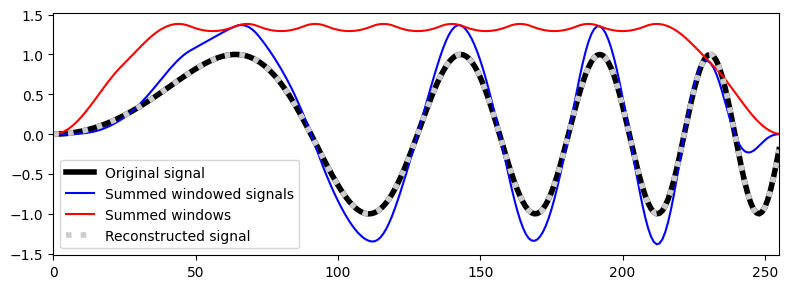

In [52]:
L = 256
t = np.arange(L) / L
omega = 4
x = np.sin(2 * np.pi * omega * t * t)

N = 64
H = 3 * N // 8
w_type = 'hann'
w = scipy.signal.get_window(w_type, N)
X = stft_basic(x, w=w, H=H)
x_rec, x_win_sum, w_sum = istft_basic(X, w=w, H=H, L=L)

plt.figure(figsize=(8, 3))
plt.plot(x, color=[0, 0, 0], linewidth=4, label='Original signal')
plt.plot(x_win_sum, 'b', label='Summed windowed signals')
plt.plot(w_sum, 'r', label='Summed windows')
plt.plot(x_rec, color=[0.8, 0.8, 0.8], linestyle=':', linewidth=4, label='Reconstructed signal')
plt.xlim([0,L-1])
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

**librosa 예제**

- 단, librosa.istft에서는 다른 윈도우 보상 방법을 사용한다.
    - $$
   x(r) = \frac{\sum_{n\in\mathbb{Z}} w(r-nH)x_n(r-nH)}{\sum_{n\in\mathbb{Z}} w(r-nH)^2},
$$

In [42]:
def print_plot(x, x_rec):
    print('Number of samples of x:    ', x.shape[0])
    print('Number of samples of x_rec:', x_rec.shape[0])
    if x.shape[0] == x_rec.shape[0]:
        print('Signals x and x_inv agree:', np.allclose(x, x_rec))
        plt.figure(figsize=(6, 2))
        plt.plot(x-x_rec, color='red')
        plt.xlim([0, x.shape[0]])
        plt.title('Differences between x and x_rec')
        plt.xlabel('Time (samples)');
        plt.tight_layout()
        plt.show()
    else:
        print('Number of samples of x and x_rec does not agree.')

=== Centered Case ===
stft: center=True; istft: center=True
Number of samples of x:     66150
Number of samples of x_rec: 66150
Signals x and x_inv agree: True


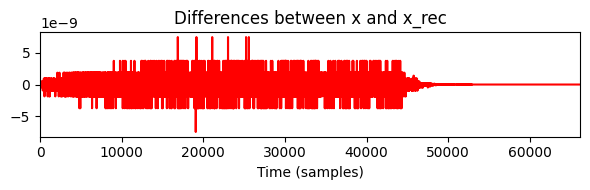

=== Non-Centered Case ===
stft: center=False; istft: center=False
Number of samples of x:     66150
Number of samples of x_rec: 66150
Signals x and x_inv agree: False


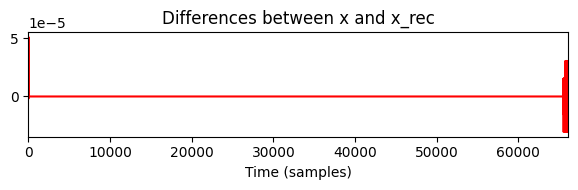

=== Centered vs. Non-Centered Case ===
stft: center=True; istft: center=False
Number of samples of x:     66150
Number of samples of x_rec: 66150
Signals x and x_inv agree: False


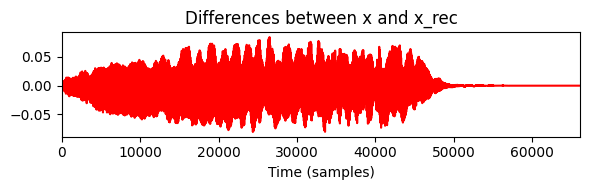

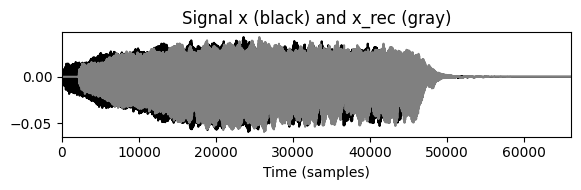

In [45]:
x, Fs = librosa.load("../audio/violin_c4_legato.wav")        
        
N = 4096
H = 2048
L = x.shape[0]

print('=== Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=True, length=L)
print('stft: center=True; istft: center=True')
print_plot(x, x_rec)

print('=== Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=False)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=False; istft: center=False')
print_plot(x, x_rec)

print('=== Centered vs. Non-Centered Case ===')
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
x_rec = librosa.istft(X, hop_length=H, win_length=N, window='hann', center=False, length=L)
print('stft: center=True; istft: center=False')
print_plot(x, x_rec)

plt.figure(figsize=(6, 2))
plt.plot(x, color='black')
plt.xlim([0, x.shape[0]])
plt.plot(x_rec, color='gray')
plt.title('Signal x (black) and x_rec (gray)')
plt.xlabel('Time (samples)');
plt.tight_layout()
plt.show()

출처: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html, https://musicinformationretrieval.com/